# Derin Öğrenme Yöntemlerinden Evrişimsel Sinir Ağları ile Duygu Tanıma

Bu projede Derin Öğrenme algoritmalarında sıkça kullanılmakta olan Evrişimsel Sinir Ağları (CNN) ile Duygu Tanıma projesini gerçekleştiriyor olacağız.

## Amaç Nedir ?

Bu projede amacımız, farklı duygulara ait görsellerden oluşan bir veri kümesindeki duyguları doğru bir şekilde tanımlamaktır.

## Veri Seti Hakkında

Veri setinde yer alan veriler, yani yüzlere ait görüntüler 48x48 piksel değerinde ve  gri tonlamalı görüntülerinden oluşmaktadır. Görev, yüz ifadesinde gösterilen duyguya göre her yüzü yedi kategoriden birine sınıflandırmaktır (0 = Kızgın, 1 = Nefret, 2 = Korku, 3 = Mutlu, 4 = Üzgün, 5 = Şaşırma, 6 = Doğal ).

- train.csv verisi, "duygu" ve "piksel" olmak üzere iki sütundan oluşmaktadır. "Duygu" sütunu, resimde bulunan duygu için 0 ile 6 arasında değişen sayısal bir değer içerir. "Piksel" sütunu ise, her görüntüye ait pixel değerlerini içermektedir.

- test.csv verisi yalnızca "piksel" değerlerinin olduğu sütununu içerir ve bizim görevimiz duygu sütununu tahmin etmektir.

- Eğitim seti 28.709 örnekten oluşmaktadır. Skor için kullanılan PublicTest seti 3.589 örnekten oluşmaktadır. Yarışmanın birincisini belirlemek için kullanılan final test seti ise 3.589 örnekten oluşuyor.

**Veri Setine erişebilmek için:** https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/overview ziyaret edebilirsiniz.


# 1) Gerekli Kütüphanelerin İmport İşlemleri

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

# 2) Veri Setinin Yüklenmesi ve İncelenmesi

In [2]:
# Veri setinin okutulması ve boyutunun incelenmesi
df = pd.read_csv("fer2013.csv")
print("Veri Setinin Boyutu:", df.shape)

Veri Setinin Boyutu: (35887, 3)


In [3]:
# Veri setinin ilk 5 gözlem birine erişilmesi
# emotion değişkeni: Duygulara ait bilgiyi içermektedir.
# pixels değişkeni: Görüntülerin pixel değerini ifade etmektedir.
# Usage: İlgili görüntünün ne amaçla kullanılacağı hakkında bilgi vermektedir. Training mi yoksa Test amaçlı mı kullanılacağı ile igili. 
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
# Usage değişkeni bir kategorik değişken olduğu için bu değişkende yer alan sınıflardan kaç adet olduğunun belirlenmesi
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
# Veri setinde Eğitim ve Test kümeleri için yer alan veri setinin boyutu
print('Eğitim setindeki örnek sayısı: %d'%(len(df[df.Usage == "Training"])),'\nTest setindeki örnek sayısı: %d'%(len(df[df.Usage == "PublicTest"])))

Eğitim setindeki örnek sayısı: 28709 
Test setindeki örnek sayısı: 3589


In [6]:
# Emotion değişkeninde kaç adet farklı yüz ifadesi yer almakta. 
df_labels_flat = df["emotion"].values.ravel()
df_labels_count = np.unique(df_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%df_labels_count)

Farklı yüz ifadelerinin sayısı: 7


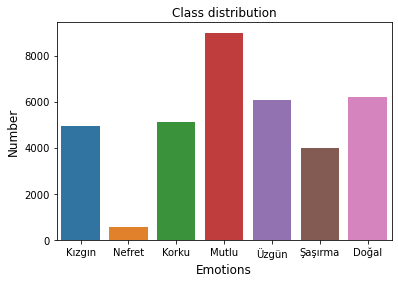

In [7]:
# Veri setinde yer alan duyguların dağılımı incelenmiştir. 
emotion_map = {0: 'Kızgın', 1: 'Nefret', 2: 'Korku', 3: 'Mutlu', 4: 'Üzgün', 5: 'Şaşırma', 6: 'Doğal'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)

plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

# 3) Veri Setinden Örnekler Gösterilmesi

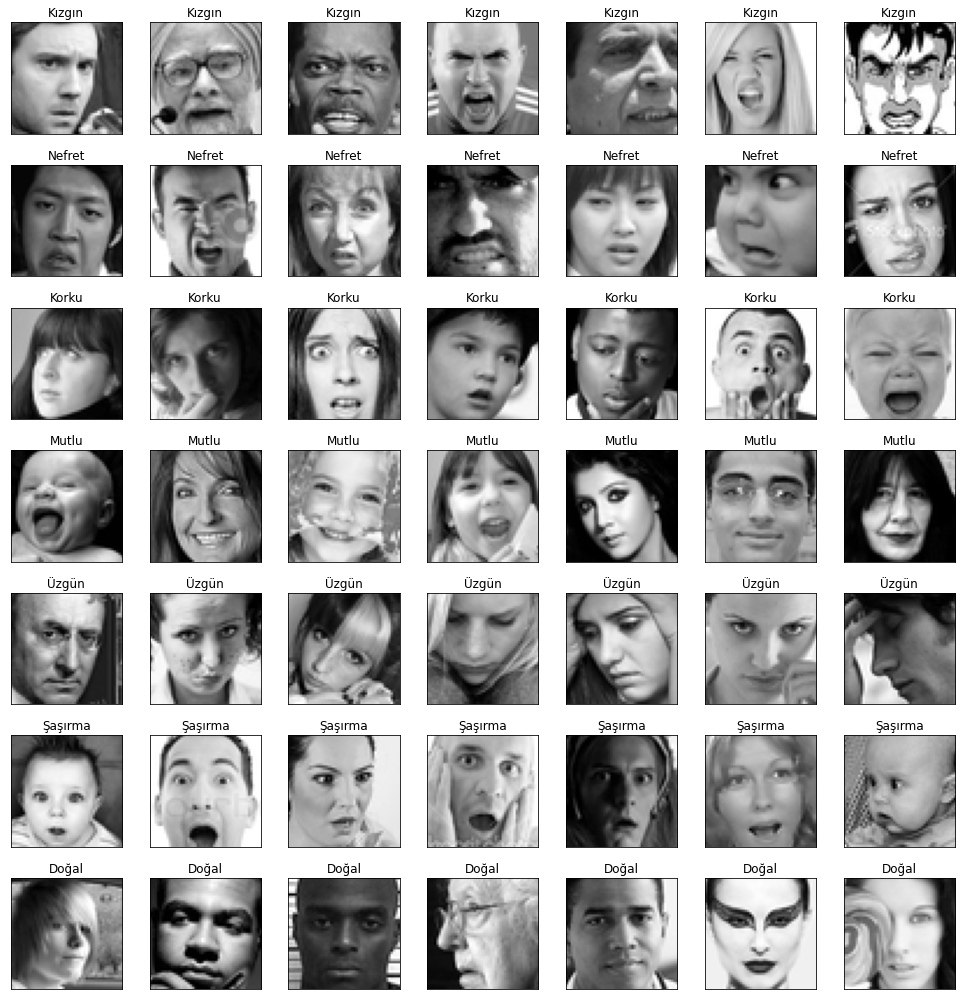

In [8]:
# Farklı yüz ifadelerinin görselleştirilmesi
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()): # 0,1,2,3,4,5,6 şeklinde sıralar.
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k] # duygu ve labeldan eşit olanların pixel değerleri tutulur. 
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32') # Burada pixeller arası boşluklar düzeltilip reshape işlemi gerçekleştirilir.

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_map[label]) # Yukarıda oluşturmuş olduğumuz sözlük yapısından duyguların isimleri başlık olarak yazdırırlır. 
        plt.tight_layout()

# 4) Veri Ön İşleme Adımları

## 4.1) Eğitim Verisi Ön İşleme Adımları

In [9]:
# Veri seti içinde yer alan Eğitim verileri train_data olarak alınmıştır. Model train_data üzerinden eğitilecektir. 
train_data = df[df.Usage == "Training"]
train_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
# Yukarıda pixel değerleri, aralarında boşluklarla ifade edilmekteydi. Bizler bunları bir matris şeklinde ifade etmemiz gerekmekte bu sebepten kaynaklı bu ön işleme adımı uygulanmaktadır. 
train_pixels = train_data.pixels.str.split(" ").tolist() 

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)

print(train_images.shape)

[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
# Eğitim verisinin Emotion değişkeninde kaç adet farklı yüz ifadesi yer almakta. 
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


## 4.2) Eğitim Verisi One Hot Encoding İşlemi

In [12]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [13]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)
y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


## 4.3) Test Verisi Ön İşleme

In [14]:
np.unique(df["Usage"].values.ravel()) 

print('Test verisetindeki örnek sayısı: %d'%(len(df[df.Usage == "PublicTest"])))

Test verisetindeki örnek sayısı: 3589


In [15]:
# Pixel değerleri, aralarında boşluklarla ifade edilmekteydi. Bizler bunları bir matris şeklinde ifade etmemiz gerekmekte bu sebepten kaynaklı bu ön işleme adımı uygulanmaktadır. 
test_data = df[df.Usage == "PublicTest"] 
test_pixels = test_data.pixels.str.split(" ").tolist() 

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images.shape)

(3589, 2304)


## 4.4) Test Verisi One Hot Encoding İşlemi

In [16]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)
y_test = y_test.astype(np.uint8)


print(y_test.shape)

(3589, 7)


# 5) Modelin Oluşturulması

In [17]:
# Model Katmanlarının Oluşturulması
model = Sequential()

#1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2.KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

#3.KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4.KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

#5.KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

#TAM BAĞLANTI KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6)) # %60 unutma işlemi gerçekleştirilmiştir.(Nöron silme)

#ÇIKIŞ KATMANI
model.add(Dense(7))
model.add(Activation('softmax')) # 7 farklı sınıf tahmin edilecek bu sebeple softmax kullanılmaktadır. 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizasyon ve başarım metriklerinin belirlenmesi
model.summary() # Modelin özeti görselleştirilmektedir.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

# 6) Eğitim ve Test Verilerinin Boyutlarının İncelenmesi

In [18]:
# Eğitim ve Test verilerinin eleman sayısı, yükseklik, genişlik ve kanal bilgilerinin ekrana yazdırılması
x_train = train_images.reshape(-1, 48, 48, 1)
x_test = test_images.reshape(-1, 48, 48, 1)
print("Train:", x_train.shape)
print("Test:", x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


In [19]:
# Eğitim ve Test kümelerinin eleman sayısı ve duygu sınıfı sayısı yazdırılması
print("Train:", y_train.shape)
print("Test:", y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


# 7) Modelin Eğitilmesi ve Ağırlıkların Kaydedilmesi

In [20]:
# En başarılı ağırlıkların kaydedilmesi
checkpointer = ModelCheckpoint(filepath="face_model.h5", verbose=1, save_best_only=True)

epochs = 15
batchSize = 100 

# Modelin Eğitilmesi
hist = model.fit(x_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# Modelin json formatında kaydedilmesi
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/15

Epoch 00001: val_loss improved from inf to 1.61011, saving model to face_model.h5
288/288 - 47s - loss: 1.9781 - accuracy: 0.2573 - val_loss: 1.6101 - val_accuracy: 0.3862
Epoch 2/15

Epoch 00002: val_loss improved from 1.61011 to 1.50367, saving model to face_model.h5
288/288 - 3s - loss: 1.6491 - accuracy: 0.3542 - val_loss: 1.5037 - val_accuracy: 0.4143
Epoch 3/15

Epoch 00003: val_loss improved from 1.50367 to 1.40434, saving model to face_model.h5
288/288 - 3s - loss: 1.5344 - accuracy: 0.4054 - val_loss: 1.4043 - val_accuracy: 0.4614
Epoch 4/15

Epoch 00004: val_loss improved from 1.40434 to 1.37248, saving model to face_model.h5
288/288 - 3s - loss: 1.4628 - accuracy: 0.4363 - val_loss: 1.3725 - val_accuracy: 0.4536
Epoch 5/15

Epoch 00005: val_loss improved from 1.37248 to 1.33395, saving model to face_model.h5
288/288 - 3s - loss: 1.4168 - accuracy: 0.4529 - val_loss: 1.3339 - val_accuracy: 0.4815
Epoch 6/15

Epoch 00006: val_loss improved from 1.33395 to 1.28779, 

# 8) Accuracy ve Loss Grafiklerinin Çizdirilmesi

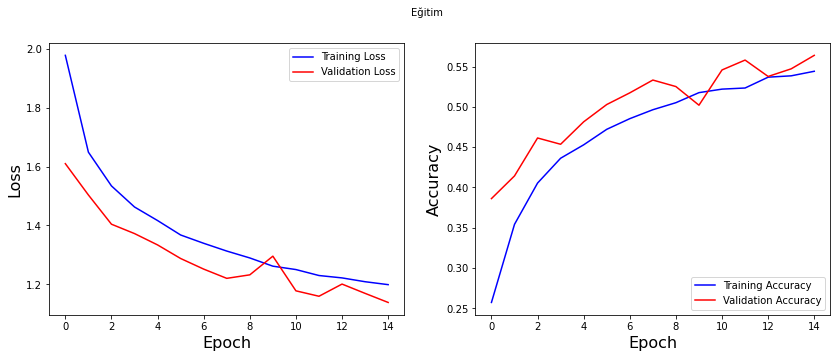

In [21]:
plt.figure(figsize=(14,5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# 9) Kaggle için Private Test Setinde Sonuçlarının Değerlendirilmesi

In [22]:
# Veri Seti içerisinde Usage değişkeninden PrivateTest olan verilerin çekilmesi. 
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [23]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [24]:
# Verinin kaç elemanı olduğu, genişlik yükseklik ve kanal bilgilerine erişim sağlanması aynı zamanda burada yer alan görüntülerin kaç adet duygu sınıfı olduğu bilgisine erişim sağlanması
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [25]:
# Doğruluk Başarımlarının incelenmesi. %55 civarında bir başarı elde edilmiştir. 
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerinde doğruluk başarımı:", score)

PrivateTest üzerinde doğruluk başarımı: [1.1347287893295288, 0.5578155517578125]


# 10) Modelin Test Edilmesi

In [26]:
# Model ağırlıklarının yüklenmesi
model.load_weights("face_model.h5")

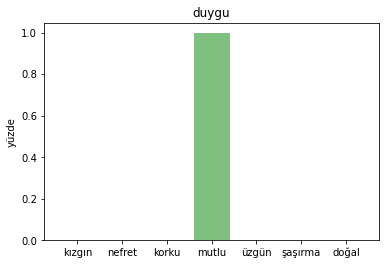

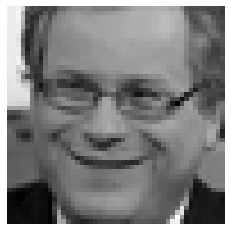

In [27]:
# Seçilen görselin model tarafından hangi duyguya ait olduğu tahmin etme işlemi gerçekleştirilmektedir. 

# Rastgele bir test setinden görüntü seçilmesi
test_image=x_test_private[46]

custom = model.predict(test_image.reshape(-1, 48, 48, 1))


# Hangi duygu sınıfa ait olduğu sutün grafiğinin çizdirilmesi
objects = ('kızgın', 'nefret', 'korku', 'mutlu', 'üzgün', 'şaşırma', 'doğal')
y_pos = np.arange(len(objects))
    
plt.bar(y_pos, custom[0], align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('yüzde')
plt.title('duygu')
plt.show()

# Rastegele seçilen görüntünün görselleştirilmesi
x = np.array(test_image, 'float32')
#x = x.reshape([-1, 48, 48, 1]);
plt.axis('off')
plt.gray()
plt.imshow(test_image.reshape(48,48))

plt.show()